# Model and Training

## Load the model

In [1]:
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    !pip install dotenv
    # Install IPPy without touching existing packages
    !pip install git+https://github.com/devangelista2/IPPy.git --no-deps

In [7]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
from utils import *
    
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Configuration
data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model
model, optimizer = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
    device=DEVICE,
)

# Print model summary
print_model_summary(model)

# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch10.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE
)

train_losses, val_losses = [], []

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch10.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch10.pth' (epoch 10)
Model ddim_unet_epoch10.pth loaded successfully to cuda, starting from epoch 10.


## Training and validation

In [8]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import *
from IPPy import metrics

# Config
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_loader = get_dataloader(
    root_dir=train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

history_file = os.path.join(model_save_dir, "history.txt")

if not os.path.exists(history_file):
    with open(history_file, "w") as f:
        f.write("Epoch\tTrain Loss\tValidation Loss\tPSNR avg\tSSIM avg\n")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

    original_images, reconstructed_images = sample_images_from_validation(
        model=model,
        noise_scheduler=noise_scheduler,
        test_loader=test_loader,
        output_dir=model_save_dir,
        num_timesteps=NUM_TRAIN_TIMESTEPS,
        device=DEVICE,
        max_examples=5,
        epoch=epoch + start_epoch,
        save_images=False,
    )


    # Compute PSNR and SSIM
    to_tensor = transforms.ToTensor()

    psnr_values = []
    ssim_values = []
    for orig, rec in zip(original_images, reconstructed_images):
        orig_t = to_tensor(orig).to(DEVICE)
        rec_t = to_tensor(rec).to(DEVICE)

        orig_t = orig_t.unsqueeze(0)
        rec_t = rec_t.unsqueeze(0)

        psnr_value = metrics.PSNR(orig_t.cpu(), rec_t.cpu())
        ssim_value = metrics.SSIM(orig_t.cpu(), rec_t.cpu())
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    psnr_avg = sum(psnr_values) / len(psnr_values)
    ssim_avg = sum(ssim_values) / len(ssim_values)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

    # Save losses in history file
    # Path to the loss history file

    with open(history_file, "a") as f:
        f.write(
            f"{epoch + start_epoch}\t"
            f"{avg_train_loss:.6f}\t"
            f"{avg_val_loss:.6f}\t"
            f"{psnr_avg:.6f}\t"
            f"{ssim_avg:.6f}\n"
        )
    print(f"History appended to {history_file}")

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 26448
Validation samples: 2616
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 10


W0522 14:17:23.533000 24533 torch/_inductor/utils.py:1250] [0/4] Not enough SMs to use max_autotune_gemm mode


[Epoch 1/20 | Step 50/1653] Train Loss: 0.005453
[Epoch 1/20 | Step 100/1653] Train Loss: 0.004130
[Epoch 1/20 | Step 150/1653] Train Loss: 0.006666
[Epoch 1/20 | Step 200/1653] Train Loss: 0.012096
[Epoch 1/20 | Step 250/1653] Train Loss: 0.014176
[Epoch 1/20 | Step 300/1653] Train Loss: 0.006214
[Epoch 1/20 | Step 350/1653] Train Loss: 0.011754
[Epoch 1/20 | Step 400/1653] Train Loss: 0.006584
[Epoch 1/20 | Step 450/1653] Train Loss: 0.002405
[Epoch 1/20 | Step 500/1653] Train Loss: 0.002591
[Epoch 1/20 | Step 550/1653] Train Loss: 0.007485
[Epoch 1/20 | Step 600/1653] Train Loss: 0.017274
[Epoch 1/20 | Step 650/1653] Train Loss: 0.010759
[Epoch 1/20 | Step 700/1653] Train Loss: 0.013540
[Epoch 1/20 | Step 750/1653] Train Loss: 0.041175
[Epoch 1/20 | Step 800/1653] Train Loss: 0.014906
[Epoch 1/20 | Step 850/1653] Train Loss: 0.006827
[Epoch 1/20 | Step 900/1653] Train Loss: 0.013456
[Epoch 1/20 | Step 950/1653] Train Loss: 0.008801
[Epoch 1/20 | Step 1000/1653] Train Loss: 0.007134


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Reconstructions:   0%|          | 0/164 [00:18<?, ?it/s]

Epoch 1 complete. Avg Train Loss: 0.013548


Epoch 1 complete. Avg Validation Loss: 0.012548
Checkpoint salvato in: checkpoints/ddim_unet_epoch11.pth
History appended to checkpoints/history.txt
[Epoch 2/20 | Step 50/1653] Train Loss: 0.052222
[Epoch 2/20 | Step 100/1653] Train Loss: 0.004795
[Epoch 2/20 | Step 150/1653] Train Loss: 0.004971
[Epoch 2/20 | Step 200/1653] Train Loss: 0.033994
[Epoch 2/20 | Step 250/1653] Train Loss: 0.006534
[Epoch 2/20 | Step 300/1653] Train Loss: 0.006264
[Epoch 2/20 | Step 350/1653] Train Loss: 0.006231
[Epoch 2/20 | Step 400/1653] Train Loss: 0.015724
[Epoch 2/20 | Step 450/1653] Train Loss: 0.008271
[Epoch 2/20 | Step 500/1653] Train Loss: 0.003785
[Epoch 2/20 | Step 550/1653] Train Loss: 0.016395
[Epoch 2/20 | Step 600/1653] Train Loss: 0.012412
[Epoch 2/20 | Step 650/1653] Train Loss: 0.076197
[Epoch 2/20 | Step 700/1653] Train Loss: 0.004118
[Epoch 2/20 | Step 750/1653] Train Loss: 0.007625
[Epoch 2/20 | Step 800/1653] Train Loss: 0.027037
[Epoch 2/20 | Step 850/1653] Train Loss: 0.007334
[E

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2 complete. Avg Train Loss: 0.013906


Epoch 2 complete. Avg Validation Loss: 0.011946
Checkpoint salvato in: checkpoints/ddim_unet_epoch12.pth
History appended to checkpoints/history.txt
[Epoch 3/20 | Step 50/1653] Train Loss: 0.013148
[Epoch 3/20 | Step 100/1653] Train Loss: 0.010083
[Epoch 3/20 | Step 150/1653] Train Loss: 0.004444
[Epoch 3/20 | Step 200/1653] Train Loss: 0.004330
[Epoch 3/20 | Step 250/1653] Train Loss: 0.003787
[Epoch 3/20 | Step 300/1653] Train Loss: 0.020243
[Epoch 3/20 | Step 350/1653] Train Loss: 0.006861
[Epoch 3/20 | Step 400/1653] Train Loss: 0.025879
[Epoch 3/20 | Step 450/1653] Train Loss: 0.002744
[Epoch 3/20 | Step 500/1653] Train Loss: 0.003524
[Epoch 3/20 | Step 550/1653] Train Loss: 0.004548
[Epoch 3/20 | Step 600/1653] Train Loss: 0.007113
[Epoch 3/20 | Step 650/1653] Train Loss: 0.005263
[Epoch 3/20 | Step 700/1653] Train Loss: 0.018948
[Epoch 3/20 | Step 750/1653] Train Loss: 0.015401
[Epoch 3/20 | Step 800/1653] Train Loss: 0.004704
[Epoch 3/20 | Step 850/1653] Train Loss: 0.004053
[E

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3 complete. Avg Train Loss: 0.013251


Epoch 3 complete. Avg Validation Loss: 0.013509
Checkpoint salvato in: checkpoints/ddim_unet_epoch13.pth
History appended to checkpoints/history.txt
[Epoch 4/20 | Step 50/1653] Train Loss: 0.005150
[Epoch 4/20 | Step 100/1653] Train Loss: 0.014535
[Epoch 4/20 | Step 150/1653] Train Loss: 0.004597
[Epoch 4/20 | Step 200/1653] Train Loss: 0.011327
[Epoch 4/20 | Step 250/1653] Train Loss: 0.005196
[Epoch 4/20 | Step 300/1653] Train Loss: 0.009640
[Epoch 4/20 | Step 350/1653] Train Loss: 0.014561
[Epoch 4/20 | Step 400/1653] Train Loss: 0.010305
[Epoch 4/20 | Step 450/1653] Train Loss: 0.005303
[Epoch 4/20 | Step 500/1653] Train Loss: 0.013298
[Epoch 4/20 | Step 550/1653] Train Loss: 0.015138
[Epoch 4/20 | Step 600/1653] Train Loss: 0.006174
[Epoch 4/20 | Step 650/1653] Train Loss: 0.006451
[Epoch 4/20 | Step 700/1653] Train Loss: 0.001470
[Epoch 4/20 | Step 750/1653] Train Loss: 0.010761
[Epoch 4/20 | Step 800/1653] Train Loss: 0.002339
[Epoch 4/20 | Step 850/1653] Train Loss: 0.006971
[E

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4 complete. Avg Train Loss: 0.013255


Epoch 4 complete. Avg Validation Loss: 0.015093
Checkpoint salvato in: checkpoints/ddim_unet_epoch14.pth
History appended to checkpoints/history.txt
[Epoch 5/20 | Step 50/1653] Train Loss: 0.020895
[Epoch 5/20 | Step 100/1653] Train Loss: 0.001725
[Epoch 5/20 | Step 150/1653] Train Loss: 0.021682
[Epoch 5/20 | Step 200/1653] Train Loss: 0.009149
[Epoch 5/20 | Step 250/1653] Train Loss: 0.006813
[Epoch 5/20 | Step 300/1653] Train Loss: 0.009420
[Epoch 5/20 | Step 350/1653] Train Loss: 0.003976
[Epoch 5/20 | Step 400/1653] Train Loss: 0.002584
[Epoch 5/20 | Step 450/1653] Train Loss: 0.014718
[Epoch 5/20 | Step 500/1653] Train Loss: 0.027391
[Epoch 5/20 | Step 550/1653] Train Loss: 0.025254
[Epoch 5/20 | Step 600/1653] Train Loss: 0.013258
[Epoch 5/20 | Step 650/1653] Train Loss: 0.008414
[Epoch 5/20 | Step 700/1653] Train Loss: 0.019357
[Epoch 5/20 | Step 750/1653] Train Loss: 0.008988
[Epoch 5/20 | Step 800/1653] Train Loss: 0.004227
[Epoch 5/20 | Step 850/1653] Train Loss: 0.013028
[E

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5 complete. Avg Train Loss: 0.012355


Epoch 5 complete. Avg Validation Loss: 0.010897
Checkpoint salvato in: checkpoints/ddim_unet_epoch15.pth
History appended to checkpoints/history.txt
[Epoch 6/20 | Step 50/1653] Train Loss: 0.003810
[Epoch 6/20 | Step 100/1653] Train Loss: 0.002576
[Epoch 6/20 | Step 150/1653] Train Loss: 0.003147
[Epoch 6/20 | Step 200/1653] Train Loss: 0.008726
[Epoch 6/20 | Step 250/1653] Train Loss: 0.018280
[Epoch 6/20 | Step 300/1653] Train Loss: 0.010173
[Epoch 6/20 | Step 350/1653] Train Loss: 0.009353
[Epoch 6/20 | Step 400/1653] Train Loss: 0.082390
[Epoch 6/20 | Step 450/1653] Train Loss: 0.013937
[Epoch 6/20 | Step 500/1653] Train Loss: 0.004436
[Epoch 6/20 | Step 550/1653] Train Loss: 0.013182
[Epoch 6/20 | Step 600/1653] Train Loss: 0.003351
[Epoch 6/20 | Step 650/1653] Train Loss: 0.003115
[Epoch 6/20 | Step 700/1653] Train Loss: 0.010343
[Epoch 6/20 | Step 750/1653] Train Loss: 0.019839
[Epoch 6/20 | Step 800/1653] Train Loss: 0.004229
[Epoch 6/20 | Step 850/1653] Train Loss: 0.034047
[E

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 6 complete. Avg Train Loss: 0.013301


Epoch 6 complete. Avg Validation Loss: 0.013276
Checkpoint salvato in: checkpoints/ddim_unet_epoch16.pth
History appended to checkpoints/history.txt
[Epoch 7/20 | Step 50/1653] Train Loss: 0.020525
[Epoch 7/20 | Step 100/1653] Train Loss: 0.009010
[Epoch 7/20 | Step 150/1653] Train Loss: 0.006955
[Epoch 7/20 | Step 200/1653] Train Loss: 0.011206
[Epoch 7/20 | Step 250/1653] Train Loss: 0.095974
[Epoch 7/20 | Step 300/1653] Train Loss: 0.007148
[Epoch 7/20 | Step 350/1653] Train Loss: 0.023417
[Epoch 7/20 | Step 400/1653] Train Loss: 0.007934
[Epoch 7/20 | Step 450/1653] Train Loss: 0.006456
[Epoch 7/20 | Step 500/1653] Train Loss: 0.012716
[Epoch 7/20 | Step 550/1653] Train Loss: 0.003260
[Epoch 7/20 | Step 600/1653] Train Loss: 0.009614
[Epoch 7/20 | Step 650/1653] Train Loss: 0.039332
[Epoch 7/20 | Step 700/1653] Train Loss: 0.003219
[Epoch 7/20 | Step 750/1653] Train Loss: 0.008442
[Epoch 7/20 | Step 800/1653] Train Loss: 0.012160
[Epoch 7/20 | Step 850/1653] Train Loss: 0.005431
[E

KeyboardInterrupt: 

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "history.txt")

# Check if file exists
if not os.path.exists(history_file):
    raise FileNotFoundError(f"Loss history file not found at: {history_file}")

# Read and parse loss history
epochs, train_losses, val_losses, psnr_avgs, ssim_avgs = [], [], [], [], []

with open(history_file, "r") as f:
    lines = f.readlines()[1:]  # Skip header
    for line in lines:
        epoch, train_loss, val_loss, psnr, ssim = line.strip().split("\t")
        epochs.append(int(epoch))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        psnr_avgs.append(float(psnr))
        ssim_avgs.append(float(ssim))

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot PSNR and SSIM
plt.figure(figsize=(8, 5))
plt.plot(epochs, psnr_avgs, label="PSNR avg")
plt.plot(epochs, ssim_avgs, label="SSIM avg")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("PSNR and SSIM Over Epochs on 5 samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'model_save_dir' is not defined

In [ ]:
from utils import *
from IPPy import metrics

ON_COLAB = False  # Set to True if running on Google Colab

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# Sample images
original_images, reconstructed_images = sample_images_from_validation(
    model=model,
    noise_scheduler=noise_scheduler,
    test_loader=test_loader,
    output_dir=RESULT_DIR,
    num_timesteps=NUM_TRAIN_TIMESTEPS,
    device=DEVICE,
    max_examples=100,
    epoch=start_epoch,
    save_images=False,
)

# Compute PSNR and SSIM between original and reconstructed images
psnr_values = []
ssim_values = []
from torchvision import transforms

to_tensor = transforms.ToTensor()

for orig, rec in zip(original_images, reconstructed_images):
    orig_t = to_tensor(orig).to(DEVICE)
    rec_t = to_tensor(rec).to(DEVICE)

    orig_t = orig_t.unsqueeze(0)
    rec_t = rec_t.unsqueeze(0)

    psnr_value = metrics.PSNR(orig_t, rec_t)
    ssim_value = metrics.SSIM(orig_t, rec_t)
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

# Print average PSNR and SSIM
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)

print(f"Average PSNR: {avg_psnr:.4f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")

Data root: raw_data
Model save directory: checkpoints
Model moved to cpu
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cpu, starting from epoch 27.


Reconstructions:   0%|          | 0/164 [00:08<?, ?it/s]

Average PSNR: 21.8242 dB
Average SSIM: 0.4676


# Evaluation

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cuda, starting from epoch 27.


Processing images: 100%|██████████| 5/5 [01:40<00:00, 20.15s/image]


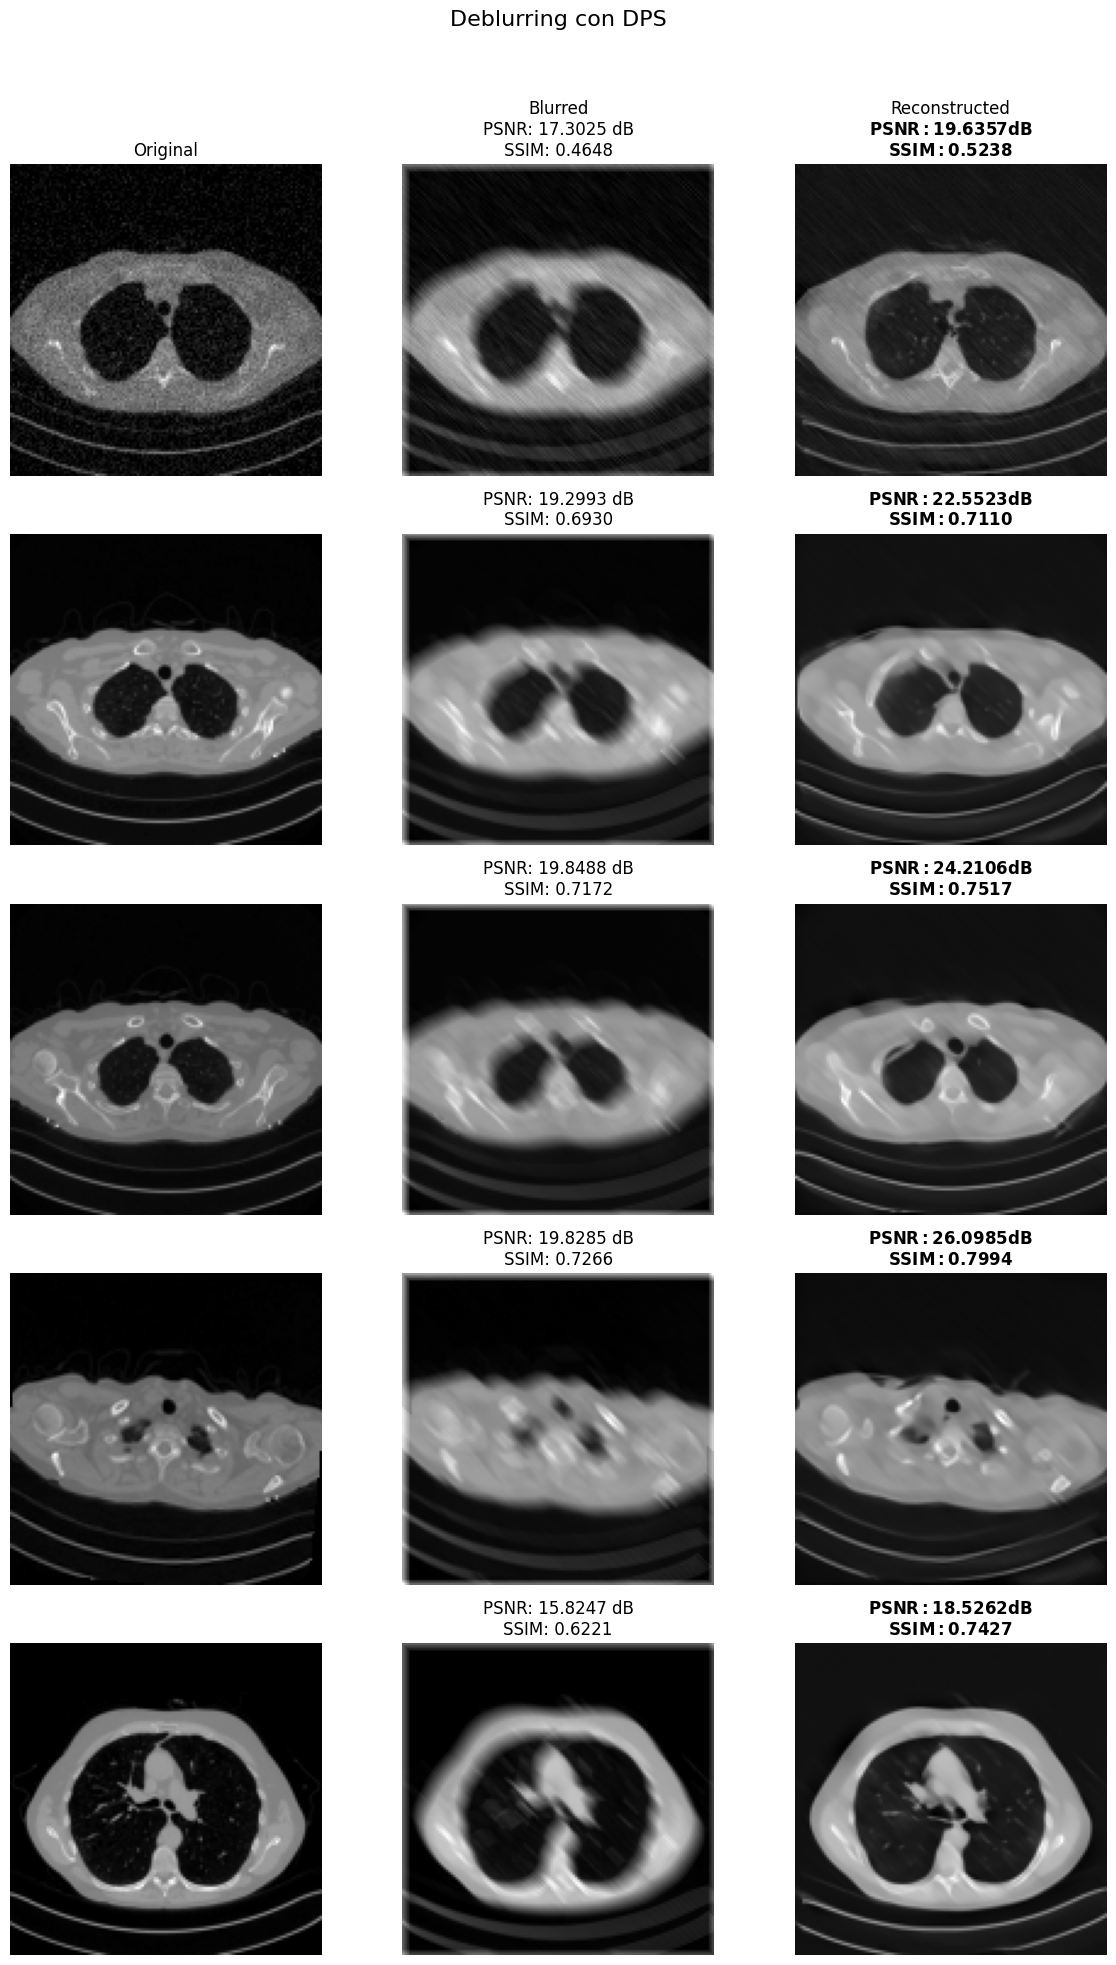

In [2]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
# random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


dps_deblur_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    ddim_scheduler=ddim_scheduler,
    noise_scheduler=noise_scheduler,
    device=DEVICE,
)

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(
/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:27: UserWarning: ASTRA toolbox not found. CTProjector will not work.
  warnings.warn("ASTRA toolbox not found. CTProjector will not work.")


Data root: raw_data
Model save directory: checkpoints


/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model moved to cuda
No checkpoint found at checkpoints/ddim_unet_epoch27.pth, starting fresh on cuda.


Processing images: 100%|██████████| 5/5 [01:46<00:00, 21.33s/image]


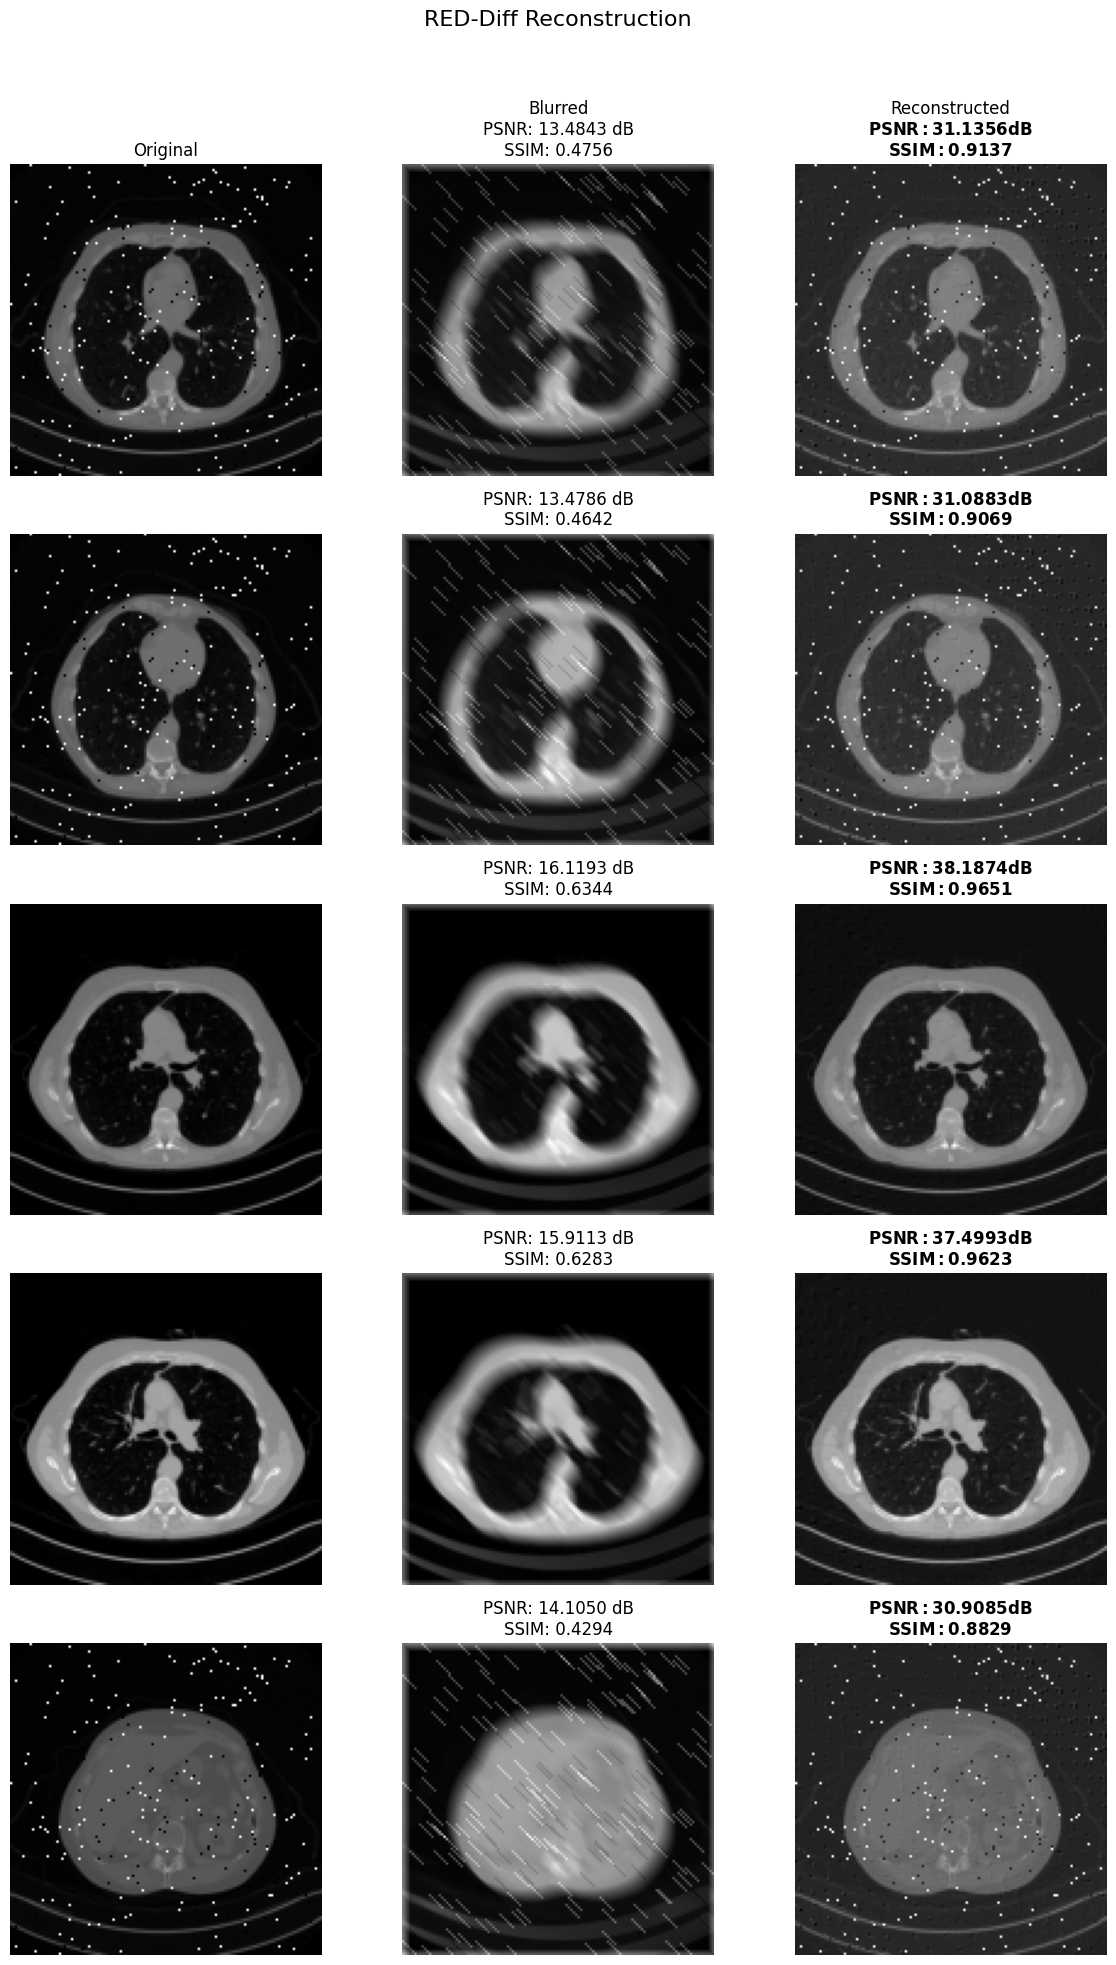

In [1]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
# random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


red_diff_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    noise_scheduler=noise_scheduler,
    ddim_scheduler=ddim_scheduler,
    device=DEVICE,
)

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cuda, starting from epoch 27.

Kernel size: 5


DPS Deblurring: 100%|██████████| 1000/1000 [00:20<00:00, 49.43it/s]     


Kernel size: 7



DPS Deblurring: 100%|██████████| 1000/1000 [00:20<00:00, 49.96it/s]     



Kernel size: 9


DPS Deblurring: 100%|██████████| 1000/1000 [00:20<00:00, 49.98it/s]     


Kernel size: 11



DPS Deblurring: 100%|██████████| 1000/1000 [00:19<00:00, 50.07it/s]     


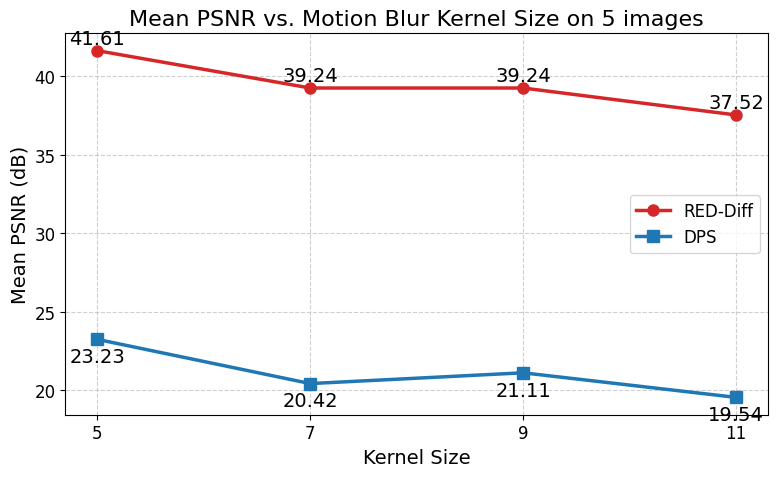

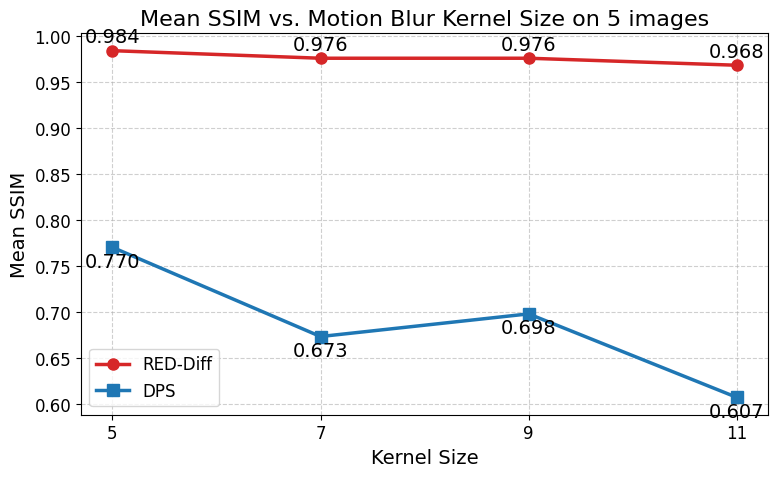

In [3]:
import torch
import os
import numpy as np
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
from tqdm import tqdm

# random.seed(42)

# Setup
ON_COLAB = False
data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)
RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & schedulers
model, optimizer = get_unet_model(device=DEVICE)
load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name="ddim_unet_epoch27.pth",
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)
noise_scheduler, ddim_scheduler = get_schedulers()

# Dataloader
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=1,  # una immagine alla volta
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# Parametri
kernel_sizes = [5, 7, 9, 11]
num_images = 5  # numero di immagini da testare

psnr_red_all = []
psnr_dps_all = []
ssim_red_all = []
ssim_dps_all = []

for kernel_size in kernel_sizes:
    print(f"\nKernel size: {kernel_size}")
    motion_angle = 45
    K = operators.Blurring(
        img_shape=(IMAGE_SIZE, IMAGE_SIZE),
        kernel_size=kernel_size,
        kernel_type="motion",
        motion_angle=motion_angle,
    )

    psnr_red, psnr_dps = [], []
    ssim_red, ssim_dps = [], []

    for i, (x_gt, _) in enumerate(test_loader):
        if i >= num_images:
            break

        x_gt = x_gt.to(DEVICE)
        y = K(x_gt).to(DEVICE)

        # RED-Diff
        x_red = red_diff(
            model=model,
            ddim_scheduler=ddim_scheduler,
            y=y,
            K=K,
            noise_scheduler=noise_scheduler,
            device=DEVICE,
        )
        psnr_red.append(metrics.PSNR(x_gt.cpu(), x_red.cpu()))
        ssim_red.append(metrics.SSIM(x_gt.cpu(), x_red.cpu()))

        # DPS
        x_dps = dps_deblur(
            model=model,
            ddim_scheduler=ddim_scheduler,
            y=y,
            K=K,
            noise_scheduler=noise_scheduler,
            device=DEVICE,
        )
        psnr_dps.append(metrics.PSNR(x_gt.cpu(), x_dps.cpu()))
        ssim_dps.append(metrics.SSIM(x_gt.cpu(), x_dps.cpu()))

    psnr_red_all.append(np.mean(psnr_red))
    psnr_dps_all.append(np.mean(psnr_dps))
    ssim_red_all.append(np.mean(ssim_red))
    ssim_dps_all.append(np.mean(ssim_dps))

# --- Common styling parameters ---
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
    }
)

# Choose a colorblind-friendly palette
colors = plt.get_cmap("tab10")

# --- PSNR Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kernel_sizes, psnr_red_all, label="RED-Diff", marker="o", color=colors(3))
ax.plot(kernel_sizes, psnr_dps_all, label="DPS", marker="s", color=colors(0))
ax.set_title(f"Mean PSNR vs. Motion Blur Kernel Size on {num_images} images")
ax.set_xlabel("Kernel Size")
ax.set_ylabel("Mean PSNR (dB)")
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(kernel_sizes)

# Annotate each point
for x, y in zip(kernel_sizes, psnr_red_all):
    ax.text(x, y + 0.2, f"{y:.2f}", ha="center", va="bottom")
for x, y in zip(kernel_sizes, psnr_dps_all):
    ax.text(x, y - 0.5, f"{y:.2f}", ha="center", va="top")

ax.legend(loc="best")
fig.tight_layout()
# fig.savefig(os.path.join(RESULT_DIR, "psnr_comparison.png"), dpi=300)
plt.show()

# --- SSIM Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kernel_sizes, ssim_red_all, label="RED-Diff", marker="o", color=colors(3))
ax.plot(kernel_sizes, ssim_dps_all, label="DPS", marker="s", color=colors(0))
ax.set_title(f"Mean SSIM vs. Motion Blur Kernel Size on {num_images} images")
ax.set_xlabel("Kernel Size")
ax.set_ylabel("Mean SSIM")
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(kernel_sizes)

# Annotate each point
for x, y in zip(kernel_sizes, ssim_red_all):
    ax.text(x, y + 0.005, f"{y:.3f}", ha="center", va="bottom")
for x, y in zip(kernel_sizes, ssim_dps_all):
    ax.text(x, y - 0.005, f"{y:.3f}", ha="center", va="top")

ax.legend(loc="best")
fig.tight_layout()
# fig.savefig(os.path.join(RESULT_DIR, "ssim_comparison.png"), dpi=300)
plt.show()